# Mapeando o teclado do piano

In [1]:
%matplotlib inline

import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math

In [2]:
def image_plot(img):
    fig, axes = plt.subplots(1, 1, figsize=(15, 6), sharex=True, sharey=True)
    axes.imshow(img)
    plt.xticks([]), plt.yticks([])
    plt.show()

In [ ]:
from utils.resourceloader import ResourceLoader

data = ResourceLoader("believer")

## Segmentar o piano na imagem

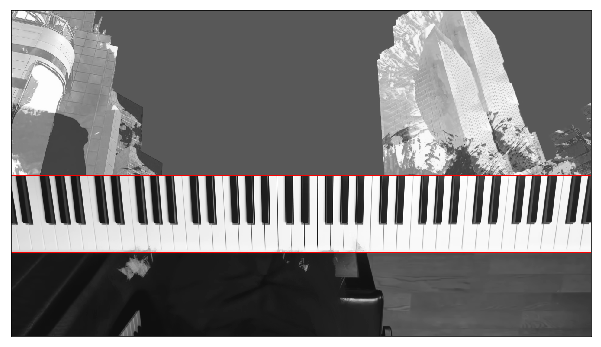

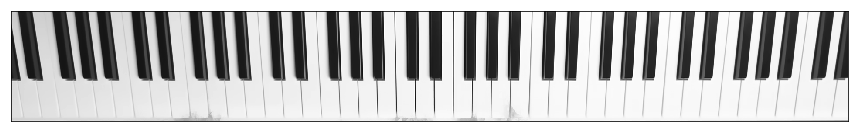

In [20]:
img_id = 1
img_name = "piano{}.bmp".format(img_id)
image = cv2.imread(img_name)
(h, w, c) = image.shape

# Marcar corte
hi, hf = [(550, 804), (548, 804)][img_id - 1]

cropped_preview = image.copy()
cv2.line(cropped_preview, (0, hi), (w-1, hi), (0, 0, 255), 3)
cv2.line(cropped_preview, (0, hf), (w-1, hf), (0, 0, 255), 3)

image_plot(cv2.cvtColor(cropped_preview, cv2.COLOR_BGR2RGB))

cropped = image[hi:hf,:]

image_plot(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))

## Binarizar a imagem para achar as teclas

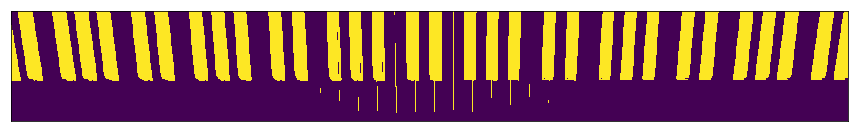

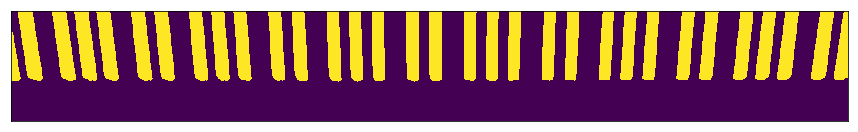

In [25]:
gsimg = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
(hh, ww) = gsimg.shape

# Binarização por Otsu
ret, thresh = cv2.threshold(gsimg, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Queremos teclas pretas, logo devemos inverter a máscara
thresh = 255 - thresh
image_plot(thresh)

# Criar um kernel para a morfologia
kernel_size = int(cropped.shape[1] * 0.005)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))

# Morfologia para fechar buracos
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
# Morfologia para tirar ruído
thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

image_plot(thresh)

## Encontrar contornos

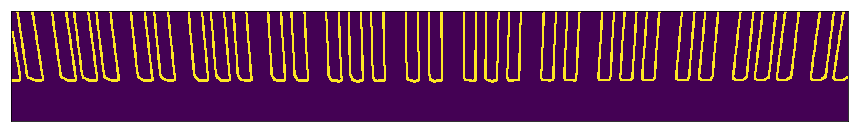

Ponto 1(-1936,160) -> Ponto 2(1935,161)


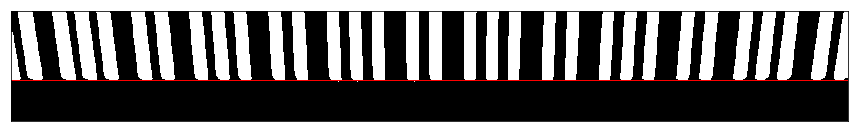

In [96]:
edges = cv2.Canny(thresh, 50, 150, apertureSize=3)
image_plot(cv2.dilate(edges, np.ones((5,5))))

# Imagem para desenhar o resultado do Hough
hough = cv2.cvtColor(thresh, cv2.COLOR_GRAY2RGB)

# Achar o fim das teclas pretas
limit_black_keys = cropped.shape[0]/2

# Hough para pegar linhas totalmente horizontais ou verticais
lines = cv2.HoughLines(edges, 1, np.pi / 2, int(cropped.shape[1] * 0.1))
number_of_keys = len(lines)

# Tamanho da diagonal da imagem
maxsize = int(np.sqrt(cropped.shape[0] ** 2 + cropped.shape[1] ** 2))

if lines is not None:
    for line in lines:
        rho, theta = line[0]

        if not (np.pi * 3/4 >= (theta % np.pi) >= np.pi * 1/4):
            continue

        a, b = np.cos(theta), np.sin(theta)

        x0, y0 = a * rho, b * rho

        x1, y1 = int(x0 + maxsize * (-b)), int(y0 + maxsize * (a))
        x2, y2 = int(x0 - maxsize * (-b)), int(y0 - maxsize * (a))

        # Desenhar
        cv2.line(hough, (x1, y1), (x2, y2), (255, 0, 0), 2)
        print("Ponto 1({},{}) -> Ponto 2({},{})".format(x1,y1,x2,y2))
        
        # Salvar esse novo limite
        limit_black_keys = min(y1, y2)
        
        break # Desenhar só uma linha

image_plot(hough)

## Encontrar os blobs que representam as teclas

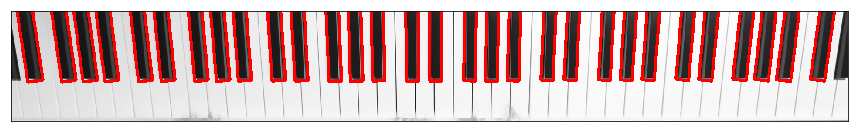

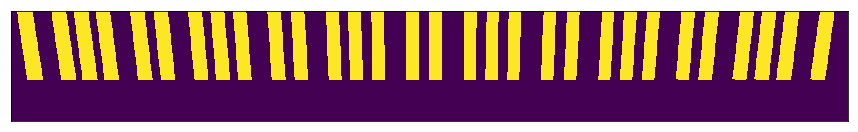

In [161]:
temp_rect = cropped.copy()
temp_mask = np.zeros(thresh.shape)

# Achar contornos
contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
num_keys = len(contours)

blobs = []

# Para cada blob ...
for cnt in contours:
    
    # Achar um retângulo que envolva o blob
    rect = cv2.minAreaRect(cnt)
    box = np.intp(cv2.boxPoints(rect))
    
    # Criar máscara do blob
    blob = np.zeros(thresh.shape).astype(int)
    cv2.fillPoly(blob, [cnt], 1)
    
    # Criar máscara do retângulo
    mask = np.zeros(thresh.shape).astype(int)
    cv2.fillPoly(mask, [box], 1)
    
    error = (mask * (1 - blob)).sum()
    if error / blob.sum() > 0.3:
        continue
    
    # Desenhar esse retângulo
    cv2.drawContours(temp_rect, [np.intp(box)], 0, (255,0,0), 5)
    cv2.fillPoly(temp_mask, [np.intp(box)], 1)

    xf1, _ = box[0]
    xi1, _ = box[1]
    xi2, _ = box[2]
    xf2, _ = box[3]
    
    blobs.append([[xi1, xf1], [xi2, xf2]])

temp_mask[limit_black_keys:,:] = 0

image_plot(temp_rect)
image_plot(temp_mask)

## Estimar início do teclado

In [147]:
# Pegar uma linha da imagem (evitar extremos devido a problemas na binarização)
keyrow = temp_mask[int(limit_black_keys/2), :]

def calc_gap(start):
    value = keyrow[start]
    accu = 1
    for i in range((start+1), len(keyrow)):
        if keyrow[i] == value:
            accu += 1
        else:
            return accu, i

# i  c  i     c  c  i     c  i     c  c  i   gaps
#  C# D#    F# G# A#    C# D#    F# G# A#    black keys
# C  D  E  F  G  A  B  C  D  E  F  G  A  B   white keys

gaps_mask = [1, 0, 1, 1, 0, 1, 0, 1, 1, 0]
n_gaps = 5
#number of black keys
n_bkeys = 5

gaps_fitness = []

for shift in range(0, n_bkeys):

    start = 0

    while keyrow[start] == 0 and start < len(keyrow):
        start += 1

    keys_values = np.zeros(n_gaps)
    gaps_values = np.zeros(n_gaps)
    mask_values = np.array(gaps_mask[shift:(shift+n_gaps)])

    for key in range(0, n_gaps):
        keys_values[key], start = calc_gap(start)
        gaps_values[key], start = calc_gap(start)
    
    fitness = (gaps_values * mask_values).sum()
    
    gaps_fitness.append(fitness)

first_key = np.array(gaps_fitness).argmin()

print( ["C#", "D#", "F#", "G#", "A#"][first_key] )

D#


In [10]:
# Ransac